# Predict molecules given a prompt

In [1]:
%reload_ext autoreload
%autoreload 2

import time
import matplotlib.pyplot as plt
plt.style.use(['science', 'nature'])
from pycm import ConfusionMatrix
import wandb
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd 

from gpt3forchem.molecules.data import get_data
from gpt3forchem.molecules.constants import TARGETS, FEATURES, CAT_TARGETS
from gpt3forchem.molecules.create_prompts import create_inverse_prompts
from gpt3forchem.fine_tune import fine_tune
from gpt3forchem.query_model import query_gpt3, extract_prediction

In [11]:
data = get_data()
data = data.loc[(data["logP"] >= -5) & (data["logP"] <= 15)]
data['logP_binned'] = pd.qcut(data['logP'], 5, labels=np.arange(5))

In [15]:
_, ranges =pd.qcut(data['logP'], 5, labels=np.arange(5), retbins=True)

In [16]:
bins = {i: (ranges[i], ranges[i + 1]) for i in range(len(ranges) - 1)}


In [17]:
bins

{0: (-4.989399999999997, 0.098),
 1: (0.098, 1.7063),
 2: (1.7063, 2.8406000000000025),
 3: (2.8406000000000025, 4.168000000000004),
 4: (4.168000000000004, 14.856799999999968)}

In [18]:
train_df, test_df = train_test_split(data, train_size=0.6)

In [19]:
train_size = len(train_df)
test_size = len(test_df)
print(f"{len(train_df)} train points and {len(test_df)} test points")


10695 train points and 7131 test points


In [20]:
train_prompts = create_inverse_prompts(train_df)
test_prompts = create_inverse_prompts(test_df)

In [21]:
completion_lengths = []

for i, row in train_prompts.iterrows(): 
    completion_lengths.append(len(row['completion']))

completion_lengths = np.array(completion_lengths)

(array([4037., 3925., 1719.,  545.,  220.,   99.,   71.,   41.,   10.,
          12.]),
 array([  5. ,  33.7,  62.4,  91.1, 119.8, 148.5, 177.2, 205.9, 234.6,
        263.3, 292. ]),
 <BarContainer object of 10 artists>)

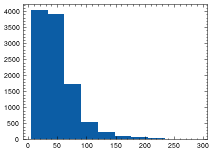

In [22]:
plt.hist(completion_lengths)

In [23]:
len(train_prompts)

10679

In [24]:
len(test_prompts)

7118

### Now, we can fine-tune the model

In [25]:
filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename = f"run_files/{filename_base}_train_inverse_prompts_mols_{train_size}.jsonl"
valid_filename = f"run_files/{filename_base}_valid_inverse_prompts_mols_{test_size}.jsonl"
# to save money, just run a small valid frame
valid_small_filename = f"run_files/{filename_base}_validsmall_inverse_prompts_mols_{test_size}.jsonl"
train_prompts.to_json(train_filename, orient="records", lines=True)
test_prompts.to_json(valid_filename, orient="records", lines=True)
test_prompts.sample(100).to_json(valid_small_filename, orient="records", lines=True)

In [26]:
fine_tune(train_filename, valid_small_filename) 

Upload progress: 100%|██████████| 1.64M/1.64M [00:00<00:00, 613Mit/s]


Uploaded file from run_files/2022-07-18-14-18-55_train_inverse_prompts_mols_10695.jsonl: file-PpfZPEaSoOcFVOc32DQoFiiD


Upload progress: 100%|██████████| 14.9k/14.9k [00:00<00:00, 17.9Mit/s]


Uploaded file from run_files/2022-07-18-14-18-55_validsmall_inverse_prompts_mols_7131.jsonl: file-H0uhTXZkP1YDe4H2x9TlH9pc
Created fine-tune: ft-s3nM44v1Sd8Yu6uW5IBopCcY
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2022-07-18 14:19:00] Created fine-tune: ft-s3nM44v1Sd8Yu6uW5IBopCcY
[2022-07-18 14:19:10] Fine-tune costs $1.19
[2022-07-18 14:19:10] Fine-tune enqueued. Queue number: 0
[2022-07-18 14:19:11] Fine-tune started
[2022-07-18 14:23:16] Completed epoch 1/4
[2022-07-18 14:27:02] Completed epoch 2/4
[2022-07-18 14:30:49] Completed epoch 3/4

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-s3nM44v1Sd8Yu6uW5IBopCcY

Fine-tune ft-s3nM44v1Sd8Yu6uW5IBopCcY has the status "running" and will not be logged
🎉 wandb sync completed successfully


In [27]:
! openai api fine_tunes.follow -i ft-s3nM44v1Sd8Yu6uW5IBopCcY

[2022-07-18 14:19:00] Created fine-tune: ft-s3nM44v1Sd8Yu6uW5IBopCcY
[2022-07-18 14:19:10] Fine-tune costs $1.19
[2022-07-18 14:19:10] Fine-tune enqueued. Queue number: 0
[2022-07-18 14:19:11] Fine-tune started
[2022-07-18 14:23:16] Completed epoch 1/4
[2022-07-18 14:27:02] Completed epoch 2/4
[2022-07-18 14:30:49] Completed epoch 3/4
[2022-07-18 14:34:37] Completed epoch 4/4
[2022-07-18 14:34:58] Uploaded model: ada:ft-epfl-2022-07-18-12-34-58
[2022-07-18 14:34:59] Uploaded result file: file-tHQw6rvj5QvzHsv04YJdN387
[2022-07-18 14:34:59] Fine-tune succeeded

Job complete! Status: succeeded 🎉
Try out your fine-tuned model:

openai api completions.create -m ada:ft-epfl-2022-07-18-12-34-58 -p <YOUR_PROMPT>


In [39]:
valid_filename

'run_files/2022-07-18-14-18-55_valid_inverse_prompts_mols_7131.jsonl'

In [28]:
test_prompts = pd.read_json(valid_filename, lines=True)

In [29]:
test_prompts['prompt'].iloc[2]

'What is a molecule with 8 C, 6 H, 0 O, 1 N, 0 P, 0 S and a logP of 2?###'

In [30]:
completions = query_gpt3("ada:ft-epfl-2022-07-18-12-34-58", test_prompts.iloc[:5], max_tokens=350)


In [32]:
from gpt3forchem.molecules.analysis import analyze_completion

In [38]:
analyze_completion(test_prompts.iloc[4]['prompt'], completions[4])

{'prompt': 'What is a molecule with 11 C, 16 H, 0 O, 0 N, 0 P, 0 S and a logP of 3?###',
 'completion': ' C1=CC=C(C=C1)C(C)C@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@',
 'smiles': 'C1=CC=C(C=C1)C(C)C',
 'predicted_log_p': 2.8100000000000014,
 'requested_log_p': 3,
 'requested_composition': {'C': 1, 'H': 6, 'O': 0, 'N': 0, 'P': 0, 'S': 0},
 'distance': 0.03060000000000107,
 'distances': [8, 6],
 'min': 6,
 'max': 8,
 'mean': 7.0,
 'expected_len': 7,
 'found_len': 21}